# Exercise 5: Cross-Validation with Symmetric Pair-Input Data



## Tiina Nokelainen 503737 tmknok@utu.fi

## Task 1 (compulsory)

1. Implemented with dividing the training set 2 different ways (getTrainSet_MLOO for modified leave-one-out and getTrainSet_LOO for normal leave-one-out)

2. See the code below and the outputs. There are plottings with c-index scores and accuracy scores included. Also maximum scores of both estimates.

3. 
    - The default leave-one-out cross-validation gives better estimate values because there are both proteins in the training set so the proteins leaks some information to the model. It would give too optimistic estimate for a pair of proteins that are not included in the training set at all. 
    - The default leave-one-out cross-validation estimates the generalisation performance for A types of pairs, where there is both proteins in the training set. The modified leave-one-out cross-validation represented in the slides don't have either of the proteins of the pair in the training set. This modified CV is a estimate for C types of pairs. 

## Task 2 (optional)


1. The type of pair the two first cv were not appropriate estimates were pair types of B - one of the proteins being present in the training set. I designed new cv and knn B_KNN
2. In my cross-validation I train the model 2 times, one time with the first protein of the pairs not present in the training set then the prediction is made, then training the model again with the second protein not being present in the training set and then prediction made for the pair again. This is a case for pairs where only one of the proteins are present in the data.
3. New CV implemented code below.
4. When k is about 23 the estimates are exactly the same (accuracy 0.737), but when the k is really high the two modified leave-one-out cross-validation estimates gets notably worse but the default loo doesn't. This is probably because similarity of other pairs gets lost in the data when k is higher. KNN doesn't work so well with higher value of k when neither or just one protein is present in the data. Maybe with weighted KNN it would work better.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

features = pd.read_csv("features.data", header=None)
labels = pd.read_csv("labels.data", header=None)
pairs = pd.read_csv("pairs.data", header=None)



# I like to have all the elements (pairs, labels, features) in one list
dataset = pd.concat([pairs, labels, features], axis=1).values


In [2]:
# INPUTS: the whole data as data, the unknown instance as instance
# RETURN: trainset without any instances that have same proteins as the unknown instanse
def getTrainSet_MLOO(data, instance): 
    
    # the pair of proteins (a and b) of the "unknown instance"
    a = instance[0]
    b = instance[1]
    
    # train set with instances not pertaining a or b proteins
    train_set = [x for x in data if x[0]!=a and x[0]!=b and x[1]!=a and x[1]!=b]
    
    return np.array(train_set)

In [3]:
# INPUTS: the whole dataset as data, index of the unknown instance as index
# RETURN: trainset without the unknown instance
def getTrainSet_LOO(data, index):
    
    # deletes the wanted instance from the dataset and stores it to train_set
    train_set = np.delete(data, (index), axis=0)
    
    return np.array(train_set)

In [4]:
# from the slides 2
# returns c-index
def cindex(predictions, truevalues):
    
    predictions = list(predictions)

    n = 0
    n_sum = 0
    for i in range(len(truevalues)):
        t = truevalues[i]
        p = predictions[i]
        for j in range(i+1,len(truevalues)):
            nt = truevalues[j]
            np = predictions[j]
            if (t != nt):
                n += 1
                if (p < np and t < nt) or (p > np and t > nt):
                        n_sum += 1
                elif p == np:
                    n_sum += 0.5
    return n_sum/n

In [5]:
# INPUTS: the whole data as data, value of k we want to use for k nearest neighbor as k
# the wanted cross validation method as CV ("mloo" as modified leave-one-out)
# RETURN: accuracy of the used CV for the dataset
def KNN(data, k, CV):
    
    # stores the predictions made to every instances to predictions-variable
    predictions = []
    # stores the true values of the instances to truevalues-variable
    truevalues = []
    
    knn = KNeighborsClassifier(n_neighbors = k)
    
    for i in range(len(data)):
        
        # if CV is "mloo", calls the method getTrainSet_MLOO which splits the data to wanted modified trainset
        if CV == "mloo":
            train_set = getTrainSet_MLOO(data, data[i])
        # else calls normal leave-one-out trainset splitter method   
        else:
            train_set = getTrainSet_LOO(data, i)
        
        X_train, Y_train = train_set[:,3:], train_set[:,2].astype('int')
        X_test = data[i][3:]
        
        knn.fit(X_train, Y_train)
        predictions += knn.predict([X_test]).tolist()
        
        truevalues += [data[i][2]]
    
    # sklearn's accuracy method
    accuracy = [k, accuracy_score(predictions, truevalues), cindex(predictions, truevalues)]
    
    return accuracy

In [34]:
# I just want know the maximums and the value of k
def my_max(list, index):
    maximum = list[0]
    
    for elem in list:
        if elem[index] > maximum[index]:
            maximum = elem
    
    return [maximum[0], maximum[index]]

In [20]:
mloo = []
loo = []

kvalues = [i for i in range(1,55,2)]

for k in kvalues:
    mloo += [KNN(dataset, k, "mloo")]
    loo += [KNN(dataset, k, "loo")]
    
accuracy_mloo = [i[1] for i in mloo]
cindex_mloo = [i[2] for i in mloo]
accuracy_loo = [i[1] for i in loo]
cindex_loo = [i[2] for i in loo]

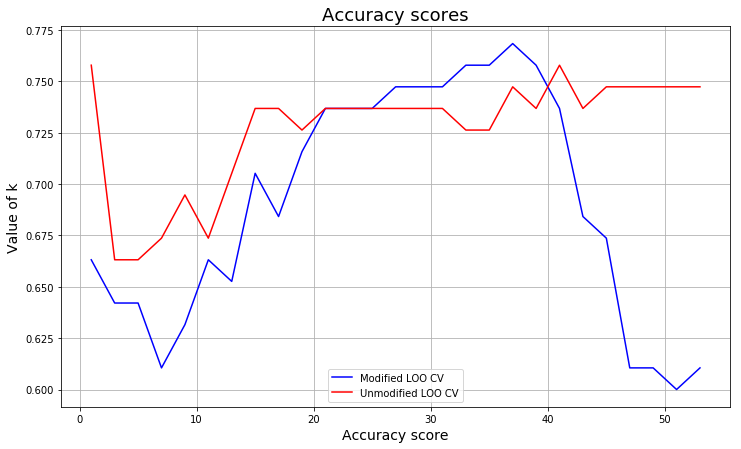

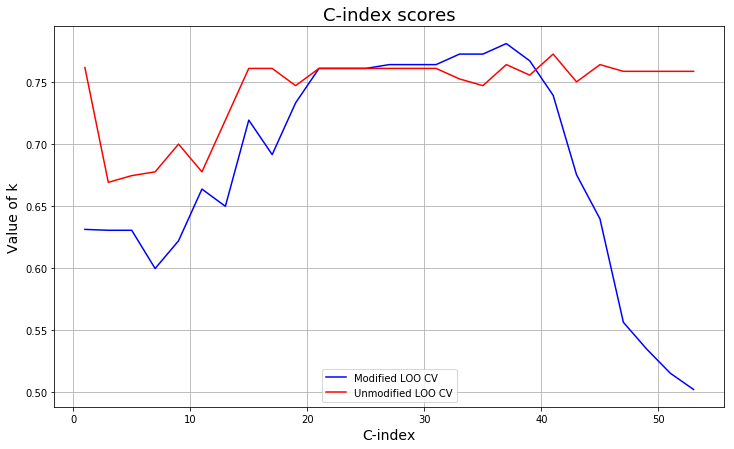

In [36]:
plt.figure(figsize=(12,7))
plt.plot(kvalues, accuracy_mloo, label="Modified LOO CV", color="blue")
plt.plot(kvalues, accuracy_loo, label="Unmodified LOO CV", color="red")
plt.xlabel('Accuracy score', fontsize=14)
plt.ylabel('Value of k', fontsize=14)
plt.title('Accuracy scores', fontsize=18)
plt.grid(True)
plt.legend(loc = 8)
plt.show()

plt.figure(figsize=(12,7))
plt.plot(kvalues, cindex_mloo, label="Modified LOO CV", color="blue")
plt.plot(kvalues, cindex_loo, label="Unmodified LOO CV", color="red")
plt.xlabel('C-index', fontsize=14)
plt.ylabel('Value of k', fontsize=14)
plt.title('C-index scores', fontsize=18)
plt.grid(True)
plt.legend(loc = 8)
plt.show()

In [23]:
# made own KNN+CV for this one because needed to train the model 2 different times
# one time with the other protein of the pair being in the train set 
# and second time with the other
def B_KNN(data, k):
    
    # stores the predictions made to every instances to predictions-variable
    predictions = []
    # stores the true values of the instances to truevalues-variable
    truevalues = []
    
    knn = KNeighborsClassifier(n_neighbors = k)
    
    for i in range(len(data)):
        
        # first prediction made with a training set including only the second protein but not the first
        train_set = getTrainSet_B(data, data[i][0])
        X_train, Y_train = train_set[:,3:], train_set[:,2].astype('int')
        X_test = data[i][3:]
        knn.fit(X_train, Y_train)
        predictions += knn.predict([X_test]).tolist()
        truevalues += [data[i][2]]

        # prediction made with a training set only including the first protein
        train_set = getTrainSet_B(data, data[i][1])
        X_train, Y_train = train_set[:,3:], train_set[:,2].astype('int')
        knn.fit(X_train, Y_train)
        predictions += knn.predict([X_test]).tolist()
        truevalues += [data[i][2]]

    # sklearn's accuracy method
    accuracy = accuracy_score(predictions, truevalues)
    cindex_score = cindex(predictions, truevalues)
    
    return [k, accuracy, cindex_score]

In [24]:
def getTrainSet_B(data, p):

    train_set = [x for x in data if x[0]!=p and x[1]!=p]
    
    return np.array(train_set)

In [26]:
mixed_loo = []

for i in kvalues:
    mixed_loo += [B_KNN(dataset, i)]

In [27]:
accuracy_B = []
cindex_B = []

for elem in mixed_loo:
    accuracy_B += [elem[1]]
    cindex_B += [elem[2]]

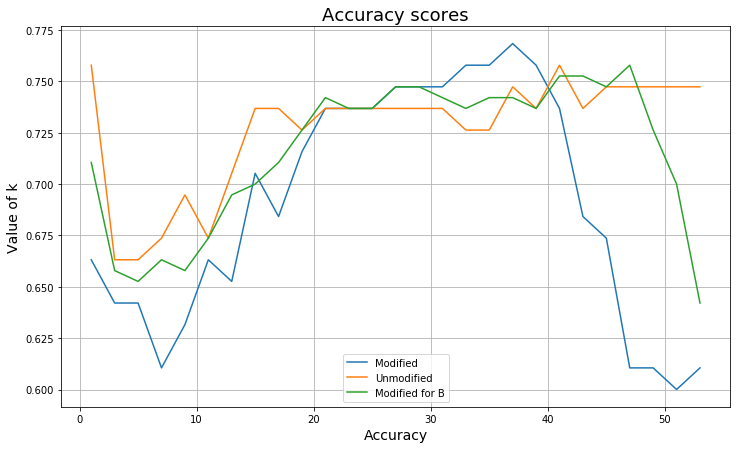

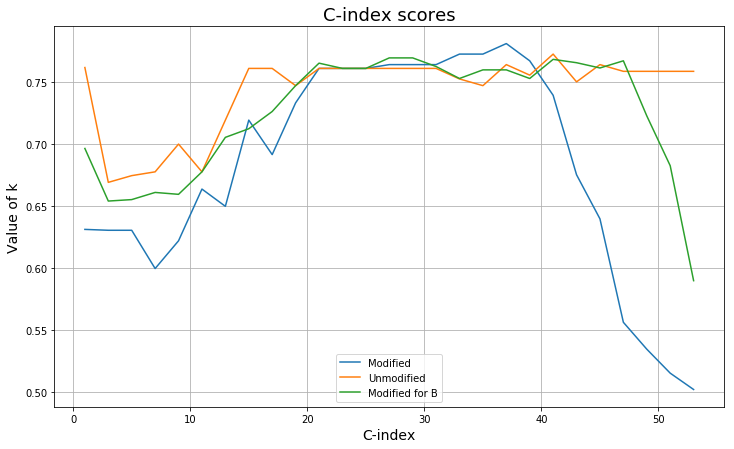

In [28]:
plt.figure(figsize=(12,7))
plt.plot(kvalues, accuracy_mloo, label="Modified")
plt.plot(kvalues, accuracy_loo, label="Unmodified")
plt.plot(kvalues, accuracy_B, label="Modified for B")
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Value of k', fontsize=14)
plt.title('Accuracy scores', fontsize=18)
plt.grid(True)
plt.legend(loc = 8)
plt.show()

plt.figure(figsize=(12,7))
plt.plot(kvalues, cindex_mloo, label="Modified")
plt.plot(kvalues, cindex_loo, label="Unmodified")
plt.plot(kvalues, cindex_B, label="Modified for B")
plt.xlabel('C-index', fontsize=14)
plt.ylabel('Value of k', fontsize=14)
plt.title('C-index scores', fontsize=18)
plt.grid(True)
plt.legend(loc = 8)
plt.show()

In [55]:
max_accu_mloo = my_max(mloo, 1)
max_accu_loo = my_max(loo, 1)
max_accu_B = my_max(mixed_loo, 1)
max_cindex_mloo = my_max(mloo, 2)
max_cindex_loo = my_max(loo, 2)
max_cindex_B = my_max(mixed_loo, 2)

print("MAXIMUM ACCURACY SCORES:")
print("default loo:", round(max_accu_loo[1], 3), "when k is", max_accu_loo[0])
print("modified for B:", round(max_accu_B[1], 3), "when k is", max_accu_B[0])
print("modified for C:", round(max_accu_mloo[1], 3), "when k is", max_accu_mloo[0])

print("\n MAXIMUM C-INDEX SCORES:")
print("default loo:", round(max_cindex_loo[1], 3), "when k is", max_cindex_loo[0])
print("modified for B:", round(max_cindex_B[1], 3), "when k is", max_cindex_B[0])
print("modified for C:", round(max_cindex_mloo[1], 3), "when k is", max_cindex_mloo[0])

MAXIMUM ACCURACY SCORES:
default loo: 0.758 when k is 1
modified for B: 0.758 when k is 47
modified for C: 0.768 when k is 37

 MAXIMUM C-INDEX SCORES:
default loo: 0.773 when k is 41
modified for B: 0.77 when k is 27
modified for C: 0.781 when k is 37


In [31]:
for i in range(len(mloo)):
    print("K =", kvalues[i], accuracy_loo[i], accuracy_B[i], accuracy_mloo[i])

K = 1 0.7578947368421053 0.7105263157894737 0.6631578947368421
K = 3 0.6631578947368421 0.6578947368421053 0.6421052631578947
K = 5 0.6631578947368421 0.6526315789473685 0.6421052631578947
K = 7 0.6736842105263158 0.6631578947368421 0.6105263157894737
K = 9 0.6947368421052632 0.6578947368421053 0.631578947368421
K = 11 0.6736842105263158 0.6736842105263158 0.6631578947368421
K = 13 0.7052631578947368 0.6947368421052632 0.6526315789473685
K = 15 0.7368421052631579 0.7 0.7052631578947368
K = 17 0.7368421052631579 0.7105263157894737 0.6842105263157895
K = 19 0.7263157894736842 0.7263157894736842 0.7157894736842105
K = 21 0.7368421052631579 0.7421052631578947 0.7368421052631579
K = 23 0.7368421052631579 0.7368421052631579 0.7368421052631579
K = 25 0.7368421052631579 0.7368421052631579 0.7368421052631579
K = 27 0.7368421052631579 0.7473684210526316 0.7473684210526316
K = 29 0.7368421052631579 0.7473684210526316 0.7473684210526316
K = 31 0.7368421052631579 0.7421052631578947 0.74736842105263

In [32]:
for i in range(len(mloo)):
    print("K =", kvalues[i], cindex_loo[i], cindex_B[i], cindex_mloo[i])

K = 1 0.7617702448210922 0.696563088512241 0.6313559322033898
K = 3 0.669256120527307 0.6541902071563088 0.6306497175141242
K = 5 0.6746704331450094 0.655367231638418 0.6306497175141242
K = 7 0.6777306967984934 0.6611346516007532 0.5998116760828626
K = 9 0.7000941619585688 0.6596045197740112 0.6221751412429378
K = 11 0.6777306967984934 0.6777306967984934 0.6638418079096046
K = 13 0.71939736346516 0.7055084745762712 0.6499529190207156
K = 15 0.7610640301318268 0.7124529190207156 0.71939736346516
K = 17 0.7610640301318268 0.7263418079096046 0.6916195856873822
K = 19 0.7471751412429378 0.7471751412429378 0.733286252354049
K = 21 0.7610640301318268 0.76530131826742 0.7610640301318268
K = 23 0.7610640301318268 0.7610640301318268 0.7610640301318268
K = 25 0.7610640301318268 0.7610640301318268 0.7610640301318268
K = 27 0.7610640301318268 0.7695386064030132 0.7641242937853108
K = 29 0.7610640301318268 0.7695386064030132 0.7641242937853108
K = 31 0.7610640301318268 0.7625941619585688 0.76412429